# Evaluación Comparativa de Random Forest y Redes Neuronales para la Detección de Asteroides Potencialmente Peligrosos (PHAs) utilizando la Base de Datos NASA SBDB



## Adquisición de Datos
Los datos se obtienen directamente de la Small-Body Database (SBDB) Query API de la NASA. El conjunto de datos incluye parámetros orbitales y físicos de objetos cercanos a la Tierra (NEOs).


In [35]:
# IMPORTACIÓN DE LIBRERÍAS CIENTÍFICAS
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Librería para Explicabilidad (eXplainable AI)
import random

# Scikit-Learn (Modelado Estadístico)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, recall_score, fbeta_score, make_scorer
)
from sklearn.impute import SimpleImputer

# TensorFlow (Redes Neuronales)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Manejo de Desbalance
from imblearn.over_sampling import SMOTE

# Configuración de Gráficos
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 6)
print("Entorno inicializado.")

Entorno inicializado.


In [ ]:
def get_nasa_asteroid_data(limit=50000, save_path="asteroids_data.csv"):
    """
    Módulo de Ingesta de Datos: Conexión API NASA SBDB.
    Implementa caché local para eficiencia en la investigación.
    """
    if os.path.exists(save_path):
        print(f"Cargando dataset local: {save_path}")
        return pd.read_csv(save_path)
    
    print(f"Conectando a NASA JPL (Solicitando {limit} registros)...")
    url = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"
    params = {
        "fields": "full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha",
        "sb-group": "neo",
        "limit": limit,
        "full-prec": "true"
    }

    try:
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data['data'], columns=data['fields'])
        df.to_csv(save_path, index=False)
        print(f"Dataset generado: {len(df)} registros.")
        return df

    except Exception as err:
        print(f"ERROR Fallo en conexión API: {err}")
        return None

df_raw = get_nasa_asteroid_data()

# --- VISTA PREVIA DEL DATASET ---
print("\n MUESTRA DE DATOS:")
pd.set_option('display.max_columns', None)
display(df_raw.head())

Cargando dataset local: asteroids_data.csv...

 MUESTRA DE DATOS:


,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha
0,433 Eros (A898 PA),1.458121,0.222836,10.828467,304.270103,178.929754,1.133199,1.783043,1.760753,46582.0,0.0,9130,10.38,0.148353,N
1,719 Albert (A911 TB),2.636590,0.546596,11.573111,183.860972,156.189404,1.195441,4.077740,4.281266,41449.0,0.0,2111,15.59,0.201318,N
2,887 Alinda (A918 AA),2.473629,0.571170,9.400060,110.405876,350.534501,1.060766,3.886491,3.890541,39281.0,0.0,5880,13.81,0.079677,N
3,1036 Ganymed (A924 UB),2.664969,0.533213,26.680736,215.441191,132.503117,1.243972,4.085966,4.350572,36982.0,0.0,12915,9.18,0.343339,N
4,1221 Amor (1932 EA1),1.919831,0.434632,11.868823,171.237188,26.758225,1.085411,2.754252,2.660130,33947.0,0.0,686,17.37,0.107969,N


## Preprocesamiento y Análisis Exploratorio (EDA)

El conjunto de datos crudo presenta desafíos típicos de datos astronómicos: valores faltantes debido a observaciones incompletas y un desbalance de clases extremo la gran mayoría de objetos son inofensivos.

1.  **Limpieza:** Eliminación de registros sin `MOID` o `H`, ya que son variables definitorias imposibles de imputar con precisión sin re-calcular órbitas.
2.  **Imputación:** Uso de la mediana para variables secundarias (`n_obs_used`, etc.).
3.  **Codificación:** Transformación de la variable objetivo `pha` (Y/N) a binario (1/0).

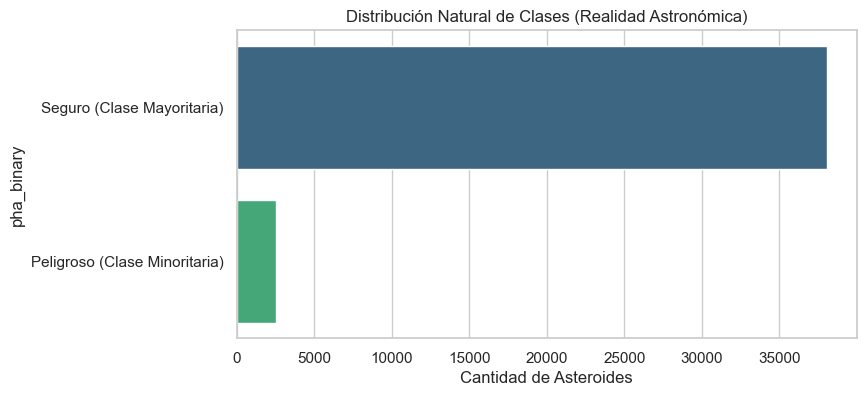

Desbalance: 93.76% Seguros vs 6.24% Peligrosos


In [37]:
def preprocess_data(df):
    df_clean = df.copy()
    
    # Conversión de tipos
    cols_numeric = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'n_obs_used', 'H', 'moid', 'condition_code']
    for col in cols_numeric:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Target Encoding
    df_clean['pha_binary'] = df_clean['pha'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

    # Filtrado de Calidad
    df_clean = df_clean.dropna(subset=['moid', 'H', 'a', 'e', 'i'])

    # Imputación Estadística
    imputer = SimpleImputer(strategy='median')
    if cols_numeric:
        df_clean[cols_numeric] = imputer.fit_transform(df_clean[cols_numeric])

    return df_clean

df_proc = preprocess_data(df_raw)

# Visualización del Desbalance
plt.figure(figsize=(8, 4))
sns.countplot(y='pha_binary', data=df_proc, palette='viridis')
plt.title('Distribución Natural de Clases (Realidad Astronómica)')
plt.yticks([0, 1], ['Seguro (Clase Mayoritaria)', 'Peligroso (Clase Minoritaria)'])
plt.xlabel('Cantidad de Asteroides')
plt.show()

ratio = df_proc['pha_binary'].value_counts(normalize=True)
print(f"Desbalance: {ratio[0]*100:.2f}% Seguros vs {ratio[1]*100:.2f}% Peligrosos")

## Balanceo Sintético (SMOTE)

Para evitar que los modelos desarrollen un sesgo hacia la clase mayoritaria aprendiendo trivialmente a predecir siempre "Seguro", aplicamos SMOTE (Synthetic Minority Over-sampling Technique).

Esta técnica genera nuevos ejemplos de asteroides peligrosos interponiendo matemáticamente vectores de características entre instancias peligrosas reales existentes en el espacio n-dimensional. Esto "enseña" al modelo la topología de la clase peligrosa sin duplicar datos idénticos.

In [38]:
# Selección de Características (Feature Selection)
features = ['a', 'e', 'i', 'om', 'w', 'q', 'H', 'moid', 'condition_code', 'n_obs_used']
X = df_proc[features]
y = df_proc['pha_binary']

# División Estratificada (80% Entrenamiento / 20% Validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de Variables (Normalización Z-Score)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicación de SMOTE (Solo en Entrenamiento)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Muestras originales: {len(y_train)}")
print(f"Muestras tras SMOTE: {len(y_train_res)} (Balanceado 50/50)")

Muestras originales: 32488
Muestras tras SMOTE: 60924 (Balanceado 50/50)


## Modelos 

Se diseñan dos modelos para la predicción de asteroides
1.  **Random Forest:** Algoritmo de ensamble basado en árboles de decisión. Robusto ante ruido y capaz de modelar fronteras de decisión no lineales complejas.
2.  **Red Neuronal Artificial (MLP):** Arquitectura feed-forward profunda con regularización (Dropout/BatchNormalization) para evitar sobreajuste.

In [39]:
# --- EXPERIMENTO A: RANDOM FOREST ---
print("Entrenando Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train_res, y_train_res)

# --- EXPERIMENTO B: RED NEURONAL PROFUNDA ---
print("Entrenando Red Neuronal")
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks para optimización
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_nn.fit(
    X_train_res, y_train_res,
    epochs=50, batch_size=64,
    validation_split=0.2, callbacks=[early_stop], verbose=0
)
print("Entrenamiento de modelos finalizado.")

Entrenando Random Forest
Entrenando Red Neuronal
Entrenamiento de modelos finalizado.


### Diagnóstico de Entrenamiento (Red Neuronal)
Visualizamos la reducción del error (Loss) durante las épocas para verificar que no haya overfitting.

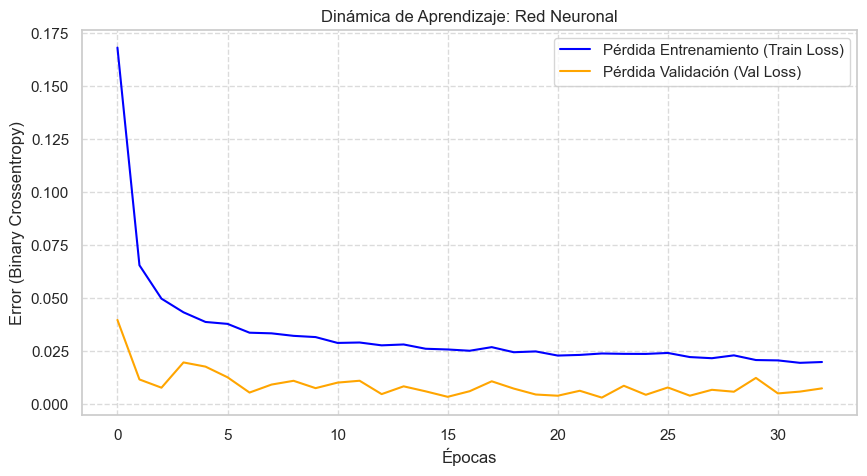

In [ ]:
if 'history' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento (Train Loss)', color='blue')
    plt.plot(history.history['val_loss'], label='Pérdida Validación (Val Loss)', color='orange')
    plt.title('Dinámica de Aprendizaje: Red Neuronal')
    plt.ylabel('Error (Binary Crossentropy)')
    plt.xlabel('Épocas')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("La variable 'history' no está disponible.")

### Diagnóstico de Entrenamiento (Random Forest)
Para analizar la curva de aprendizaje de Random Forest, evaluamos cómo mejora el rendimiento (Recall) a medida que aumenta el tamaño del conjunto de entrenamiento. Esto nos indica si el modelo se beneficiaría de más datos o si ya ha convergido.

Generando curva de aprendizaje para Random Forest


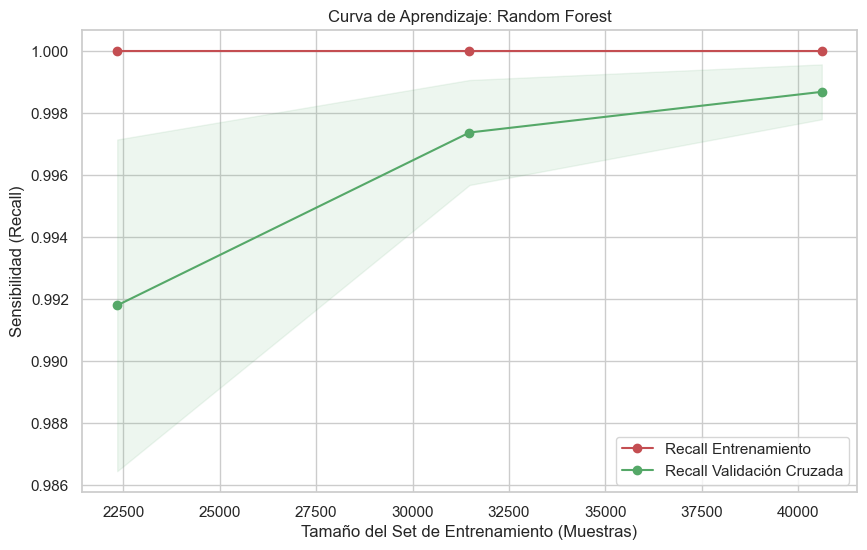

In [41]:
print("Generando curva de aprendizaje para Random Forest")
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model, 
    X=X_train_res, 
    y=y_train_res, 
    train_sizes=np.linspace(0.1, 1.0, 5), # Evaluar al 10%, 32%, 55%, 77% y 100% de datos
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Calcular promedios y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Recall Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Recall Validación Cruzada")

# Áreas de incertidumbre
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Curva de Aprendizaje: Random Forest")
plt.xlabel("Tamaño del Set de Entrenamiento (Muestras)")
plt.ylabel("Sensibilidad (Recall)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Resultados

Para evaluar la eficacia de los modelos en un contexto de defensa planetaria, la métrica Accuracy (Exactitud) es insuficiente y potencialmente engañosa. 

Nos enfocamos en el Recall (Sensibilidad) de la clase "Peligroso". Un falso negativo no detectar una amenaza real tiene un coste infinitamente mayor que un falso positivo (falsa alarma). 

### Matrices de Confusión
Las matrices de confusión nos permiten visualizar exactamente en qué clases se equivocan los modelos. Buscamos minimizar el cuadrante inferior izquierdo (Falsos Negativos).

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


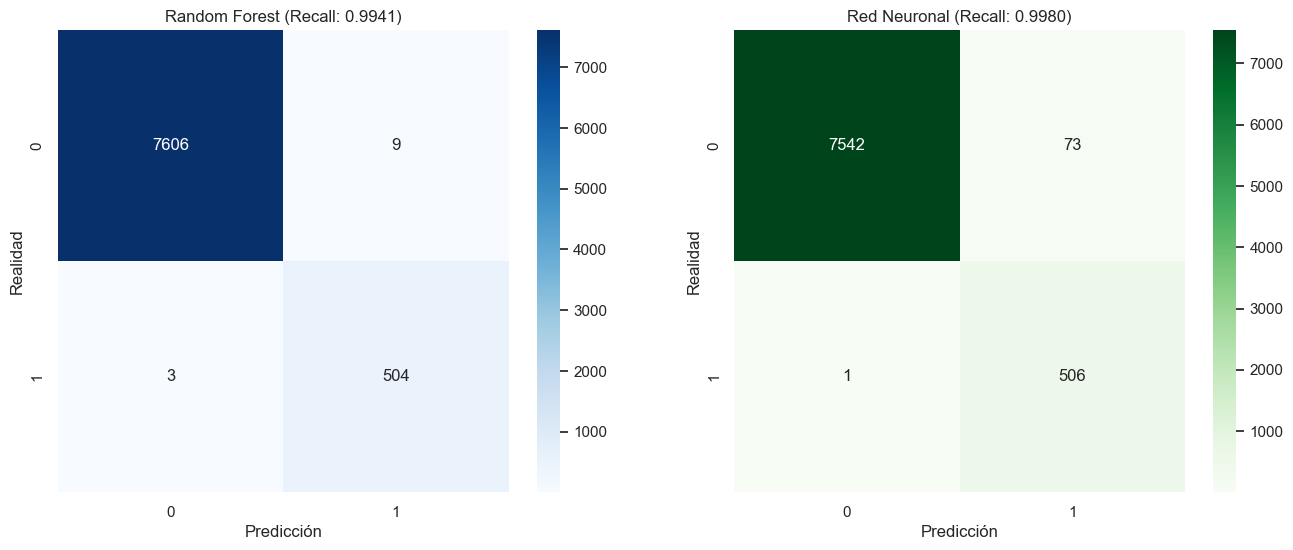


=== REPORTE RANDOM FOREST ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7615
           1       0.98      0.99      0.99       507

    accuracy                           1.00      8122
   macro avg       0.99      1.00      0.99      8122
weighted avg       1.00      1.00      1.00      8122


=== REPORTE RED NEURONAL ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7615
           1       0.87      1.00      0.93       507

    accuracy                           0.99      8122
   macro avg       0.94      0.99      0.96      8122
weighted avg       0.99      0.99      0.99      8122



In [42]:
# Generación de Métricas
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

y_prob_nn = model_nn.predict(X_test_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Visualización de Matrices de Confusión
def plot_comparison(y_test, pred_rf, pred_nn):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title(f'Random Forest (Recall: {recall_score(y_test, pred_rf):.4f})')
    ax[0].set_xlabel('Predicción'); ax[0].set_ylabel('Realidad')
    
    sns.heatmap(confusion_matrix(y_test, pred_nn), annot=True, fmt='d', cmap='Greens', ax=ax[1])
    ax[1].set_title(f'Red Neuronal (Recall: {recall_score(y_test, pred_nn):.4f})')
    ax[1].set_xlabel('Predicción'); ax[1].set_ylabel('Realidad')
    plt.show()

plot_comparison(y_test, y_pred_rf, y_pred_nn)

# Tabla de Métricas Detallada
print("\n=== REPORTE RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf))
print("\n=== REPORTE RED NEURONAL ===")
print(classification_report(y_test, y_pred_nn))

### F2-Score y Validación Cruzada
Además de las métricas estándar, incorporamos el*F2-Score, que pondera el Recall el doble que la precisión, priorizando la seguridad. También aplicamos Validación Cruzada Estratificada para garantizar la estabilidad estadística.

In [43]:
# Definir F2-Score como métrica
f2_scorer = make_scorer(fbeta_score, beta=2)

print("Ejecutando Validación Cruzada (5-Folds) para Random Forest")
# Usamos StratifiedKFold para mantener el balance de clases en cada fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring=f2_scorer, n_jobs=-1)

print(f"\n Resultados de Validación Cruzada (F2-Score):")
print(f"Scores por Fold: {cv_scores}")
print(f"Media F2-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Ejecutando Validación Cruzada (5-Folds) para Random Forest

 Resultados de Validación Cruzada (F2-Score):
Scores por Fold: [0.99865424 0.99858822 0.99894951 0.99898247 0.99904806]
Media F2-Score: 0.9988 (+/- 0.0004)


### Análisis de Explicabilidad Comparativa (SHAP Values)
Para validar que ambos modelos "entienden" la física y no solo memorizan, comparamos qué variables pesan más en sus decisiones. Utilizaremos KernelExplainer para la Red Neuronal (aproximación) y TreeExplainer para el Random Forest.

Generando SHAP...


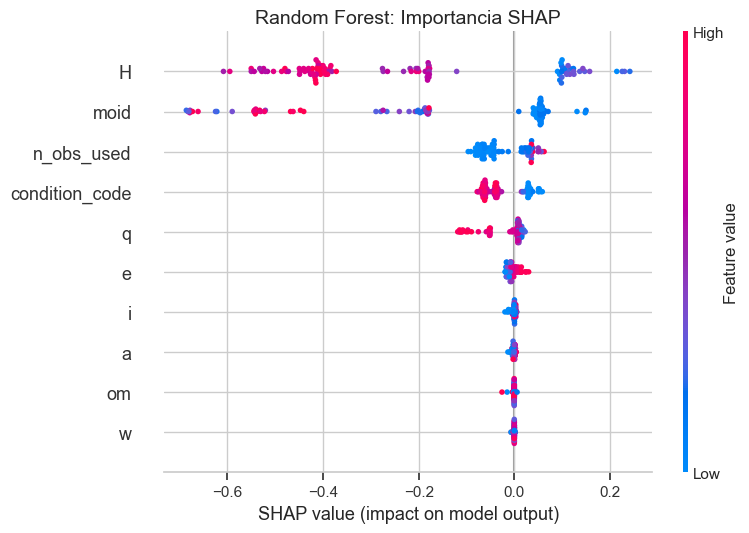

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1597/1597 ━

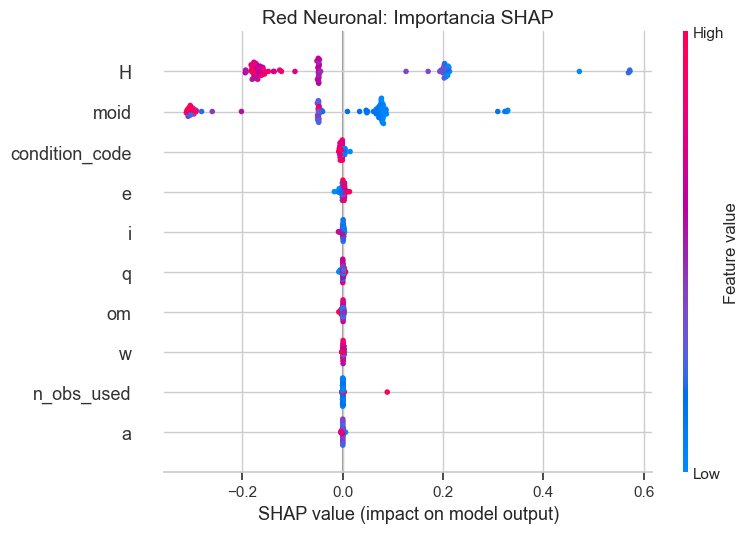

Completado


In [44]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('shap').setLevel(logging.ERROR)

print("Generando SHAP...") 

# RANDOM FOREST
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_scaled[:100], check_additivity=False)

if isinstance(shap_values_rf, list):
    shap_data_rf = shap_values_rf[1]
elif len(shap_values_rf.shape) == 3:
    shap_data_rf = shap_values_rf[:, :, 1]
else:
    shap_data_rf = shap_values_rf

plt.figure(figsize=(10,6))
shap.summary_plot(shap_data_rf, X_test_scaled[:100], feature_names=features, show=False)
plt.title('Random Forest: Importancia SHAP', fontsize=14)
plt.tight_layout()
plt.show()

# RED NEURONAL
background = shap.sample(X_train_scaled, 50, random_state=42)
explainer_nn = shap.KernelExplainer(model_nn.predict, background)
shap_values_nn = explainer_nn.shap_values(X_test_scaled[:100], silent=True)

if isinstance(shap_values_nn, list):
    shap_data_nn = shap_values_nn[0]
else:
    shap_data_nn = shap_values_nn
    
if len(shap_data_nn.shape) == 3:
    shap_data_nn = shap_data_nn[:, :, 0]

plt.figure(figsize=(10,6))
shap.summary_plot(shap_data_nn, X_test_scaled[:100], feature_names=features, show=False)
plt.title('Red Neuronal: Importancia SHAP', fontsize=14)
plt.tight_layout()
plt.show()

print("Completado")

## Simulación
El sistema simula un entorno de operación real utilizando un subconjunto de datos de prueba Test Set no vistos previamente, seleccionando aleatoriamente muestras balanceadas de objetos peligrosos y seguros para someter a los modelos a una prueba de estrés controlada y verificable, contrastando las predicciones de ambas arquitecturas Random Forest vs Red Neuronal simultáneamente.

In [45]:
def run_simulation():
    print("\n--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---")
    print("Objetivo: Validación integral con datos físicos (Tamaño, MOID) y confianza por modelo.\n")
    
    # 1. Muestreo Estratificado
    dang_indices = y_test[y_test == 1].index.tolist()
    safe_indices = y_test[y_test == 0].index.tolist()
    
    sample_dang = random.sample(dang_indices, 5)
    sample_safe = random.sample(safe_indices, 5)
    simulation_indices = sample_dang + sample_safe
    random.shuffle(simulation_indices)
    
    results = []
    
    for idx in simulation_indices:
        # Recuperar datos de entrada (features)
        obj_data = X_test.loc[idx].values.reshape(1, -1)
        obj_data_scaled = scaler.transform(obj_data)
        
        # --- RECUPERACIÓN DE METADATA (Nombre y Diámetro) ---
        real_name = "Unknown"
        diameter_val = "N/A"
        
        # Intentar buscar en df_raw (dataset original sin procesar)
        try:
            row_raw = df_raw.loc[idx]
            real_name = row_raw['full_name']
            
            # Intentar obtener diámetro real si existe
            if 'diameter' in df_raw.columns and not pd.isna(row_raw['diameter']):
                d = float(row_raw['diameter'])
                diameter_val = f"{d:.3f} km"
            else:
                # Estimación basada en H (Albedo as 0.14)
                h_val = X_test.loc[idx]['H']
                est_diam = 1329 / (math.sqrt(0.14)) * (10 ** (-0.2 * h_val))
                diameter_val = f"~{est_diam:.3f} km*"
        except:
            # Fallback a df_proc o ID genérico
            try: real_name = df_proc.loc[idx]['full_name']
            except: real_name = f"ID_{idx}"
            
            # Estimación fallback
            h_val = X_test.loc[idx]['H']
            est_diam = 1329 / (3.74) * (10 ** (-0.2 * h_val))
            diameter_val = f"~{est_diam:.3f} km*"
        
        # Predicciones
        p_rf = rf_model.predict_proba(obj_data_scaled)[0][1]
        p_nn = model_nn.predict(obj_data_scaled, verbose=0).flatten()[0]
        
        results.append({
            'Objeto': real_name,
            'MOID (AU)': f"{X_test.loc[idx]['moid']:.4f}",
            'Mag (H)': f"{X_test.loc[idx]['H']:.1f}",
            'Diámetro': diameter_val,
            'Realidad': 'PELIGRO' if y_test.loc[idx] == 1 else 'Seguro',
            'RF Pred': 'PELIGRO' if p_rf > 0.5 else 'Seguro',
            'RF Conf': f"{p_rf*100:.1f}%",
            'NN Pred': 'PELIGRO' if p_nn > 0.5 else 'Seguro',
            'NN Conf': f"{p_nn*100:.1f}%"
        })

    res_df = pd.DataFrame(results)
    
    def style_table(styler):
        styler.applymap(lambda v: 'color: red; font-weight: bold' if v == 'PELIGRO' else 'color: green', subset=['Realidad'])
        styler.applymap(lambda v: 'background-color: #ffcccc' if v == 'PELIGRO' else 'background-color: #ccffcc', subset=['RF Pred', 'NN Pred'])
        return styler
    
    try:
        display(style_table(res_df.style))
    except:
        display(res_df)
    
    print("\n* Diámetro estimado basado en Magnitud H (Albedo 0.14) cuando el dato real no está disponible.")
    print("MOID: Distancia Mínima de Intersección Orbital (Menor a 0.05 AU es potencialmente peligroso).")

run_simulation()



--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---
Objetivo: Validación integral con datos físicos (Tamaño, MOID) y confianza por modelo.



,Objeto,MOID (AU),Mag (H),Diámetro,Realidad,RF Pred,RF Conf,NN Pred,NN Conf
0,(2022 UO4),0.0129,25.2,~0.003 km*,Seguro,Seguro,0.0%,Seguro,0.0%
1,141851 (2002 PM6),0.0389,17.8,~0.097 km*,PELIGRO,PELIGRO,100.0%,PELIGRO,100.0%
2,(2025 UK1),0.1829,23.5,~0.007 km*,Seguro,Seguro,0.0%,Seguro,0.0%
3,(2019 VN4),0.0419,25.7,~0.003 km*,Seguro,Seguro,1.0%,Seguro,0.0%
4,(2019 QH4),0.0258,24.6,~0.004 km*,Seguro,Seguro,0.0%,Seguro,0.0%
5,244977 (2004 BE68),0.0108,18.4,~0.076 km*,PELIGRO,PELIGRO,99.8%,PELIGRO,100.0%
6,(2022 RE4),0.0460,20.6,~0.027 km*,PELIGRO,PELIGRO,100.0%,PELIGRO,99.1%
7,(2008 SR1),0.0251,20.3,~0.031 km*,PELIGRO,PELIGRO,99.9%,PELIGRO,100.0%
8,26663 (2000 XK47),0.0351,18.2,~0.083 km*,PELIGRO,PELIGRO,99.9%,PELIGRO,100.0%
9,(2015 CB),0.0508,23.2,~0.008 km*,Seguro,Seguro,1.0%,Seguro,0.0%



* Diámetro estimado basado en Magnitud H (Albedo 0.14) cuando el dato real no está disponible.
MOID: Distancia Mínima de Intersección Orbital (Menor a 0.05 AU es potencialmente peligroso).
